# Climatic Analysis
Performing climatic analysis of Hawaii based on the temperature recorded on different stations

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.sql import label
from sqlalchemy import func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import pandas as pd
from sqlalchemy import Column, Integer, String, Numeric, Text, Float,Table,ForeignKey
from flask import jsonify

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

from datetime import datetime,timedelta

In [3]:
#Create engine,Reflect Database into ORM classes and map tables
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

Measurements = Base.classes.measurements
Stations = Base.classes.stations


In [4]:
# create a session
session = Session(engine)

my_table = Table('Measurements', Base.metadata, 
    Column("station", String, ForeignKey("Stations.station")),
    autoload=True,autoload_with=engine)

### Precipitation Analysis

In [5]:
#Test the return values
measurements_year = session.query(Measurements.date,Measurements.prcp).limit(10).all()
for mammal in measurements_year:
    print(mammal)

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', 0.0)
('2010-01-07', 0.06)
('2010-01-08', 0.0)
('2010-01-09', 0.0)
('2010-01-10', 0.0)
('2010-01-11', 0.01)


In [6]:
def precipitation_data():
    #Get date for last year 
    current_time = datetime.now()
    past_year = current_time - timedelta(days=365)
    measurements_year = session.query(Measurements.date,Measurements.prcp).filter(Measurements.date > past_year).all()
    
    #created dictionary to get the data
    measure_records = []
    for measure in measurements_year:
        measure_records.append(measure._asdict())
    
    #dictionary to dataframe
    measurements_df = pd.DataFrame.from_records(measure_records)
    measurements_df = measurements_df.set_index('date')

    return measurements_df

In [7]:
#call function to get the datat
measurements_df=precipitation_data()

In [8]:
measurements_df.head()

,prcp
date,
2017-02-05,0.00
2017-02-06,0.00
2017-02-07,0.51
2017-02-08,0.00
2017-02-09,0.00


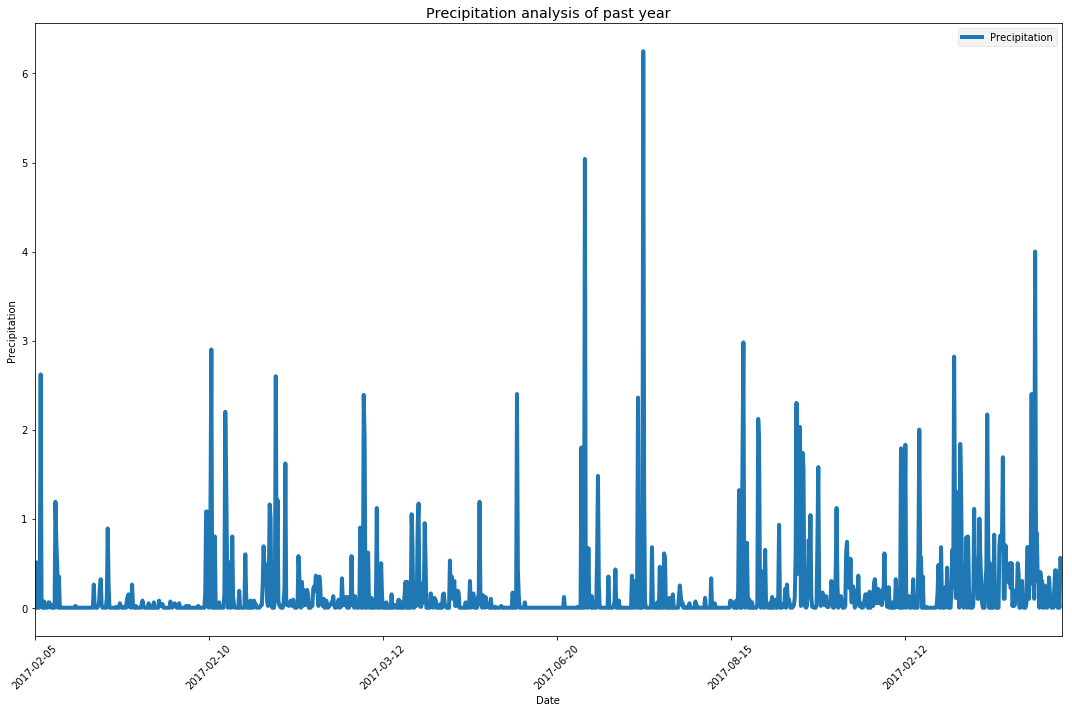

In [9]:
#Plot graph statistics for the precipitation data
measurements_df = precipitation_data()
measurements_df.plot(kind="line",linewidth=4,figsize=(15,10))
plt.style.use('fivethirtyeight')

matplotlib.rcParams.update({'font.size': 10})
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title(f"Precipitation analysis of past year")
plt.xticks(rotation=45)
plt.legend(["Precipitation"])
plt.tight_layout()
plt.savefig("PrecipitationAnalysis_Hawaii.png")
plt.show()


### Station Analysis

In [10]:
#query to calculate the total number of stations.
total_stations = session.query(Stations).distinct().count()

In [11]:
total_stations

9

In [12]:
conn = engine.connect()
conn.execute("select * from stations ").fetchall()

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
# sql query :
#select Stations.name,Stations.station,count(measurements.id) as countM from measurements join stations
#on stations.station = measurements.station
#group by stations.name,stations.station
#order  by countM desc


# Get the list of descending order obervation station.Highest first
def station_whighfreq():
    active_stations = session.query(Stations.name,Stations.station,label('number_of_obs',func.count(Measurements.id))).\
                    filter(Measurements.station == Stations.station).group_by(Stations.name,Stations.station).order_by(func.count(Measurements.id).desc())
    
    active_station_records = []
    for station in active_stations:
        active_station_records.append(station._asdict())

    active_station_df = pd.DataFrame.from_records(active_station_records)
    return active_station_df

In [14]:
#Get the highest station_id ,List the stations and observation counts in descending order
active_station_df= station_whighfreq()
active_station_df

,name,number_of_obs,station
0,"WAIHEE 837.5, HI US",2772,USC00519281
1,"WAIKIKI 717.2, HI US",2724,USC00519397
2,"KANEOHE 838.1, HI US",2709,USC00513117
3,"WAIMANALO EXPERIMENTAL FARM, HI US",2669,USC00519523
4,"MANOA LYON ARBO 785.2, HI US",2612,USC00516128
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202,USC00514830
6,"HONOLULU OBSERVATORY 702.2, HI US",1979,USC00511918
7,"PEARL CITY, HI US",1372,USC00517948
8,"UPPER WAHIAWA 874.3, HI US",511,USC00518838


In [15]:
#Get the station_id and name for the station has the highest number of observations
freq_station = {'id':"",'name':""}
freq_station['id'] = active_station_df.iloc[:1]['station'][0]
freq_station['name'] = active_station_df.iloc[:1]['name'][0]

In [16]:
freq_station['id']

'USC00519281'

In [17]:
conn.execute("select * from Measurements limit 10 ").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-06', 0.0, 73),
 (6, 'USC00519397', '2010-01-07', 0.06, 70),
 (7, 'USC00519397', '2010-01-08', 0.0, 64),
 (8, 'USC00519397', '2010-01-09', 0.0, 68),
 (9, 'USC00519397', '2010-01-10', 0.0, 73),
 (10, 'USC00519397', '2010-01-11', 0.01, 64)]

In [18]:
def getstationslist():
    active_station_df = stations_wfrequency()
    stations = active_station_df[['name','station']]
    return stations

In [19]:
# last 12 months of temperature observation data (tobs) for the station with highest frequency
def temp_data():
    #Get date for last year 
    current_time = datetime.now()
    past_year = current_time - timedelta(days=365)
    print(current_time)
    print(past_year)
    #add the most frequesncy station_id
    freq_station_id = freq_station['id']
    
    temp_year = session.query(Measurements.date,Measurements.tobs).filter(Measurements.station == freq_station_id).\
    filter(Measurements.date > past_year).all()
    
    #created dictionary to get the data
    measure_records = []
    for measure in temp_year:
        measure_records.append(measure._asdict())
    
    #dictionary to dataframe
    temp_df = pd.DataFrame.from_records(measure_records)
    temp_df = temp_df.set_index('date')

    return temp_df


In [20]:
temperature_df=temp_data()
temperature_df.head()

2018-02-04 20:00:45.081289
2017-02-04 20:00:45.081289


,tobs
date,
2017-02-05,73
2017-02-06,75
2017-02-07,64
2017-02-08,59
2017-02-09,59


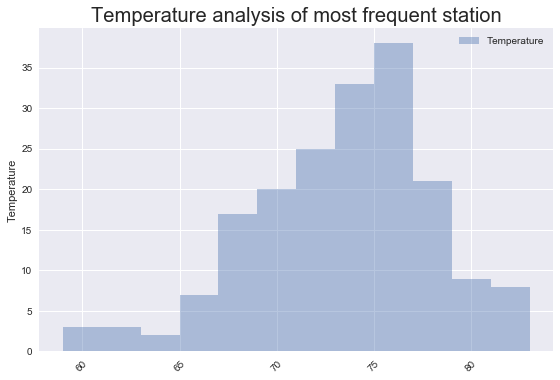

In [21]:
#Plot the results as a histogram with bins=12.
import seaborn as sns

#sns.distplot(temperature_df.tobs)
sns.distplot(temperature_df, bins=12, kde=False)
#temperature_df.plot(kind="hist",linewidth=4,figsize=(10,5))
plt.style.use('fivethirtyeight')

plt.ylabel("Temperature")
plt.title(f"Temperature analysis of most frequent station")
plt.xticks(rotation=45)
plt.legend(["Temperature"])
plt.tight_layout()
plt.savefig("TemperatureAnalysis_Hawaii.png")
plt.show()

### Temperature Analysis

In [22]:
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
#and return the minimum, average, and maximum temperatures for that range of dates.
startdate = "2016-01-02"
enddate = "2017-01-20"

def calc_temps(startdate,enddate):
    temperature_vacation = session.query(label('max_temp',func.max(Measurements.tobs)),\
                                     label('min_temp',func.min(Measurements.tobs)),\
                                     label('avg_temp',func.avg(Measurements.tobs))).\
                    filter(Measurements.date >= startdate).\
                    filter(Measurements.date <= enddate )

    Max_temp = temperature_vacation[0].max_temp
    Min_temp = temperature_vacation[0].min_temp
    Avg_temp = temperature_vacation[0].avg_temp

    print("Tempture for date range:",Max_temp ,Min_temp,Avg_temp) 
    


In [27]:
yourstartdate=datetime.strptime(input('Enter End date in the format %Y-%m-%d'), '%Y-%m-%d')
#startdate = "2018-01-02"
yourenddate=datetime.strptime(input('Enter End date in the format %Y-%m-%d'), '%Y-%m-%d')
calc_temps(yourstartdate,yourenddate)

Enter End date in the format %Y-%m-%d2017-01-02
Enter End date in the format %Y-%m-%d2017-02-20
Tempture for date range: 81 59 69.80718954248366


In [28]:
#get the date in yyyy-mm-dd format and show "last year" same date range
#min and max and average tempture for that and show data for previous year
def calc_tempsLast(startdate,enddate):
    #for last year do-365days
    compstart = startdate - timedelta(days=365)
    compend = enddate - timedelta(days=365)

    temperature_vacation = session.query(label('max_temp',func.max(Measurements.tobs)),\
                                     label('min_temp',func.min(Measurements.tobs)),\
                                     label('avg_temp',func.avg(Measurements.tobs))).\
                    filter(Measurements.date >= compstart).\
                    filter(Measurements.date <= compend )

    Max_temp = temperature_vacation[0].max_temp
    Min_temp = temperature_vacation[0].min_temp
    Avg_temp = temperature_vacation[0].avg_temp

    print("Last year tempature for same date range :Max Temp,MIN temp,Avg temp :", Max_temp,Min_temp,Avg_temp) 
    
    yerror = Max_temp - Min_temp
    
    barvalue = [Avg_temp]
    xvals = range(len(barvalue))
    matplotlib.rcParams.update({'font.size': 12})
    
    fig,ax = plt.subplots(figsize=(5,8))
    ax.bar(xvals, barvalue, yerr=yerror, color='g',alpha=0.6)
    ax.set_xticks([1]) 
    plt.xlabel("Vacation time period")
    plt.ylabel("Temperature")
    plt.title("Trip average temperature")
    plt.tight_layout()
    plt.savefig("Tripavg.png")
    
    plt.show()
    
    

In [29]:
#Get input from user for date range
startdate=datetime.strptime(input('Enter End date in the format m/d/y'), '%Y-%m-%d')
#startdate = "2018-01-02"
enddate=datetime.strptime(input('Enter End date in the format m/d/y'), '%Y-%m-%d')
#enddate = "2018-01-20"
print(startdate)
print(enddate)

Enter End date in the format m/d/y2018-01-02
Enter End date in the format m/d/y2018-01-20
2018-01-02 00:00:00
2018-01-20 00:00:00


Last year tempature for same date range :Max Temp,MIN temp,Avg temp : 81 60 69.51351351351352


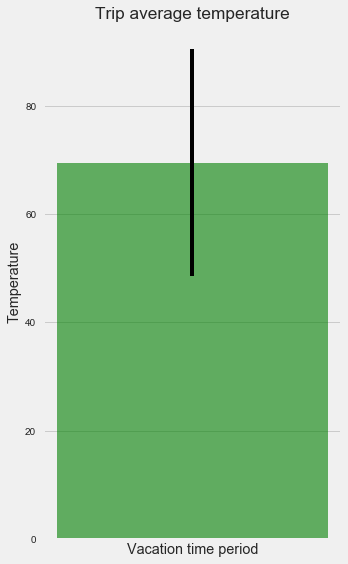

In [30]:
#Call function to get lastyear data 
calc_tempsLast(startdate,enddate)

In [31]:
current_time = datetime.now()
print(current_time)
past_year = current_time - timedelta(days=365)
print(past_year)

2018-02-04 20:04:04.929176
2017-02-04 20:04:04.929176


In [32]:
#differnet formates for dates
now= datetime.now() #get the current date and time
#%c - local date and time, %x-local's date, %X- local's time
print(now.strftime("%c"))
print(now.strftime("%x"))
print(now.strftime("%X"))
##### Time Formatting ####
#%I/%H - 12/24 Hour, %M - minute, %S - second, %p - local's AM/PM
print(now.strftime("%I:%M:%S %p")) # 12-Hour:Minute:Second:AM
print(now.strftime("%Y/%m/%d")) # 12-Hour:Minute:Second:AM
print(now.strftime("%H:%M")) # 24-Hour:Minute

Sun Feb  4 20:04:13 2018
02/04/18
20:04:13
08:04:13 PM
2018/02/04
20:04


### Optional Recommended Analysis

In [33]:
#Calcualte the rainfall per weather station using the previous year's matching dates.
#get the date in yyyy-mm-dd format and show "last year" same date range
#min and max and average tempture for that and show data for previous year
def calcrainfalll(startdate,enddate):
    #for -365 for last year dates
    compstart = startdate - timedelta(days=365)
    compend = enddate - timedelta(days=365)
    
    rainfall_per_station = session.query(Stations.name,Stations.station,label('avg_rainfall',func.avg(Measurements.prcp))).\
                    filter(Measurements.station == Stations.station).\
                    filter(Measurements.date >= compstart).\
                    filter(Measurements.date <= compend).group_by(Stations.name,Stations.station).order_by(func.avg(Measurements.prcp))
    
    active_station_records = []
    for station in rainfall_per_station:
        active_station_records.append(station._asdict())

    rainfall_df = pd.DataFrame.from_records(active_station_records)
         
    return rainfall_df  


In [34]:
#Get input from user for date range
rstartdate=datetime.strptime(input('Enter End date in the format yyyy/mm/dd : '), '%Y-%m-%d')
#startdate = "2018-01-02"
renddate=datetime.strptime(input('Enter End date in the format yyyy/mm/dd : '), '%Y-%m-%d')
#enddate = "2018-01-20"
print(rstartdate)
print(renddate)

calcrainfalll(rstartdate,renddate)
   

Enter End date in the format yyyy/mm/dd : 2018-01-02
Enter End date in the format yyyy/mm/dd : 2018-02-20
2018-01-02 00:00:00
2018-02-20 00:00:00


,avg_rainfall,name,station
0,0.001724,"PEARL CITY, HI US",USC00517948
1,0.080204,"WAIKIKI 717.2, HI US",USC00519397
2,0.160244,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830
3,0.177755,"KANEOHE 838.1, HI US",USC00513117
4,0.177755,"WAIHEE 837.5, HI US",USC00519281
5,0.202143,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523
6,0.258723,"MANOA LYON ARBO 785.2, HI US",USC00516128


In [35]:
#Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.
def dailynormals(startdate,enddate):
    #get the date in m/d format and go back 365days
    compstart = datetime.strptime(startdate,"%m-%d") - timedelta(days=365)
    compend = datetime.strptime(enddate,"%m-%d") - timedelta(days=365)
    #compstart = startdate - timedelta(days=365)
    #compend = enddate - timedelta(days=365)
    #replace year to2017 as the m/d give record1999
    compstart = compstart.replace(year = 2017)
    compend = compend.replace(year = 2017)
        
    daily_temperatures = session.query(Measurements.date,label('tmax',func.max(Measurements.tobs)),\
                                      label('tmin',func.min(Measurements.tobs)),
                                      label('tavg',func.avg(Measurements.tobs)),).\
                    filter(Measurements.date >= compstart).\
                    filter(Measurements.date <= compend).group_by(Measurements.date).order_by(Measurements.date)
    
    daily_records = []
    for station in  daily_temperatures:
        daily_records.append(station._asdict())

    dailytemp_df = pd.DataFrame.from_records(daily_records)
         
    return dailytemp_df 

In [36]:
#Get input from user for date range
drstartdate=datetime.strptime(input('Enter End date in the format yyyy/mm/dd : '), '%Y-%m-%d')
drenddate=datetime.strptime(input('Enter End date in the format yyyy/mm/dd : '), '%Y-%m-%d')
print(drstartdate)
print(drenddate)



Enter End date in the format yyyy/mm/dd : 2018-01-02
Enter End date in the format yyyy/mm/dd : 2018-02-20
2018-01-02 00:00:00
2018-02-20 00:00:00


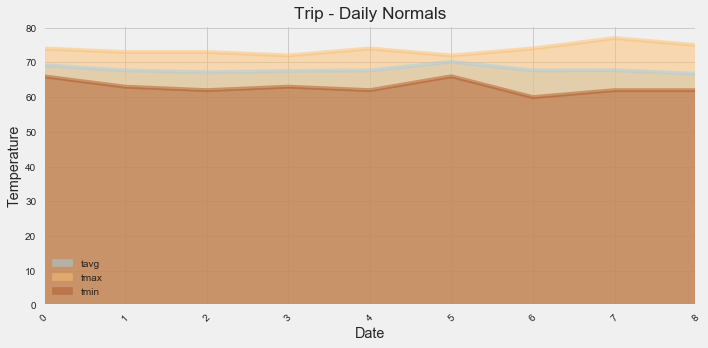

In [38]:
#Pandas to plot an area plot (stacked=False) for the daily normals.
daily_df = dailynormals('01-01','01-10')
daily_df.plot(kind='area',stacked=False,figsize=(10,5),alpha=0.50,cmap = cm.get_cmap('Paired'))

plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"Trip - Daily Normals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("trip_dailynormals.png")

plt.show()